# Test SR model

In [ ]:
import numpy as np 
import torch
from PIL import Image
import matplotlib.pyplot as plt

# 假设你的项目路径配置正确
from src.emcfsys.EMCellFiner.hat.models.hat_model import HATModel
from src.emcfsys.EMCellFiner.hat.models.img_utils import tensor2img

# 1. 初始化模型
path = r"D:\napari_EMCF\EMCFsys\models\EMCellFiner.pth"
# 显式指定 tile_size，防止显存溢出；对于小图可以不用 tile
model = HATModel(scale=4, tile_size=512) 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# 2. 读取与预处理
img_path = r"D:\napari_EMCF\EMCFsys\emcfsys\image\Bock2011_2951_XrV1ciGgTWHjepNf.tif"
img = Image.open(img_path).convert("RGB")

# 转换为 Numpy 并归一化
img_np = np.array(img).astype(np.float32) / 255.
# 转换为 Tensor: (H, W, C) -> (C, H, W) -> (1, C, H, W)
img_torch = torch.from_numpy(img_np).permute(2, 0, 1).unsqueeze(0).to(device)
print(f"Input Shape: {img_torch.shape}")
# 3. 推理
with torch.no_grad():
    output = model(img_torch) 
print(f"Output Shape: {output.shape}")
# 4. 后处理
output = output.cpu()
img_out = tensor2img(output, rgb2bgr=False, min_max=(0, 1))
# 5. 转回 PIL 图片
img_final = Image.fromarray(img_out)

# 验证结果
# img_final.show() 
# img_final.save("result_sr.png")
print("Done.")

In [ ]:
from src.emcfsys.EMCellFiner.hat.models.inference_hat import hat_infer_numpy
from src.emcfsys.EMCellFiner.hat.models.hat_model import HATModel
from PIL import Image
import numpy as np
import torch
import time
start = time.time()
img_path = r"D:\napari_EMCF\EMCFsys\emcfsys\image\Bock2011_2951_XrV1ciGgTWHjepNf.tif"
img = Image.open(img_path).convert("RGB").crop([0,0,512,512])
img_np = np.array(img)

model = HATModel(scale=4, tile_size=512)
device = "cpu" #torch.device("cuda" if torch.cuda.is_available() else "cpu")

out = hat_infer_numpy(
    model= model,
    image= img_np,
    device=device,
)

end = time.time()
print("inference time: ", end - start)

# add torch.compile

In [ ]:
from src.emcfsys.EMCellFiner.hat.models.inference_hat import hat_infer_numpy
from src.emcfsys.EMCellFiner.hat.models.hat_model import HATModel
from PIL import Image
import numpy as np
import torch
import time
start = time.time()
img_path = r"D:\napari_EMCF\EMCFsys\emcfsys\image\Bock2011_2951_XrV1ciGgTWHjepNf.tif"
img = Image.open(img_path).convert("RGB").crop([0,0,512,512])
img_np = np.array(img)

model = HATModel(scale=4, tile_size=512)
device = "cuda" #torch.device("cuda" if torch.cuda.is_available() else "cpu")

out = hat_infer_numpy(
    model= model,
    image= img_np,
    device=device,
)

end = time.time()
print("inference time: ", end - start)

# Export model to ONNX

## ONNX can't speed up many times1!

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
from src.emcfsys.EMCellFiner.hat.models.hat_arch import HAT

model = HAT()

state_dict = torch.load(r"D:\napari_EMCF\EMCFsys\models\EMCellFiner.pth", map_location='cpu')
model.load_state_dict(state_dict['params'], strict=True)


def export_hat_to_onnx(model, onnx_path="HATModel.onnx", device="cpu"):
    """
    导出 HAT 网络到 ONNX
    注意：tile_process 不会导出，只能做整张图推理
    """
    model.eval()
    model.to(device)

    # 示例输入
    dummy_input = torch.randn(1, 3, 64, 64, device=device)  # B,C,H,W

    # 导出 ONNX
    torch.onnx.export(
        model,
        dummy_input,
        onnx_path,
        export_params=True,
        opset_version=17,
        do_constant_folding=True,
        input_names=['input'],
        output_names=['output'],
        dynamic_axes={
            'input': {2: 'height', 3: 'width'},
            'output': {2: 'height', 3: 'width'},
        }
    )
    print(f"✅ ONNX model saved at {onnx_path}")

export_hat_to_onnx(model, onnx_path="HATModel.onnx", device="cpu")

In [ ]:
import onnxruntime as ort
import numpy as np
from PIL import Image
from src.emcfsys.EMCellFiner.hat.models.img_utils import tensor2img
import torch
import time
start = time.time()
ort_sess = ort.InferenceSession("HATModel.onnx")

input_name = ort_sess.get_inputs()[0].name
output_name = ort_sess.get_outputs()[0].name

img_path = r"src\emcfsys\test_imgs\test_img.tif"
image = np.array(Image.open(img_path).convert("RGB").crop([0,0,512,512]))/255.

img_tensor = torch.from_numpy(image).permute(2, 0, 1).unsqueeze(0).numpy().astype(np.float32)

out = ort_sess.run([output_name], {input_name: img_tensor})
# out[0] to image 1, 3, 256, 256 -> 256, 256, 3
out = torch.from_numpy(np.array(out))
out = tensor2img(out, rgb2bgr=False, min_max=(0, 1))
end = time.time()

print("inference time: ", end - start)
print(out.shape)
print(out.max())

In [ ]:
Image.fromarray(out)

In [ ]:
from urllib.request import urlopen
from PIL import Image
import timm

img = Image.open(urlopen(
    'https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/beignets-task-guide.png'
))

model = timm.create_model('vit_small_patch16_dinov3.lvd1689m', pretrained=True)
model = model.eval()

# get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(model)
transforms = timm.data.create_transform(**data_config, is_training=False)

output = model(transforms(img).unsqueeze(0))  # unsqueeze single image into batch of 1

top5_probabilities, top5_class_indices = torch.topk(output.softmax(dim=1) * 100, k=5)


# test the train

In [ ]:
from src.emcfsys.EMCellFound.train import train_loop

img_dir = r"D:\napari_EMCF\EMCFsys\emcfsys\image"
label_dir = r"D:\napari_EMCF\EMCFsys\emcfsys\label"
save_dir = r"D:\napari_EMCF\EMCFsys\models"

train_loop(img_dir, 
           label_dir, 
           save_dir, 
           model_name='deeplabv3plus',
           backbone_name='convnext_base',
           pretrained = True,
           pretrained_model=None,
           lr=1e-3, batch_size=4, 
           epochs=100, device=None,
           callback=None, target_size=(512, 512), 
           classes_num=2, ignore_index=-1)

model.safetensors:   0%|          | 0.00/354M [00:00<?, ?B/s]

c:\Users\YZY\miniconda3\envs\EMCF_napari\Lib\site-packages\huggingface_hub\file_download.py:121: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\YZY\.cache\huggingface\hub\models--timm--convnext_base.fb_in22k_ft_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


New best model found at epoch 1! IoU=0.6281
New best model found at epoch 2! IoU=0.7630
New best model found at epoch 3! IoU=0.7692
New best model found at epoch 4! IoU=0.8142


# Inference the seg model

(512, 512) [0 1]


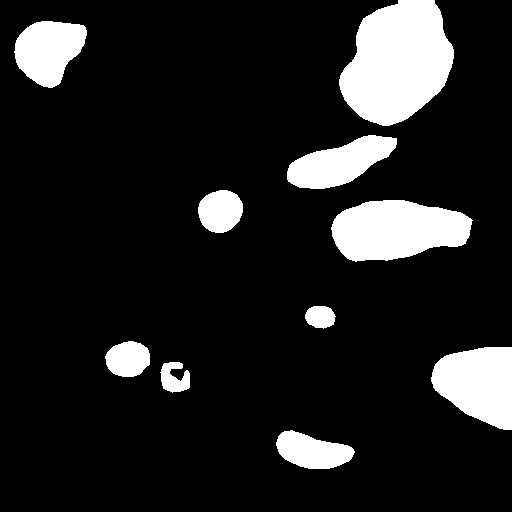

In [12]:
from src.emcfsys.EMCellFound.inference import infer_numpy, load_model
from src.emcfsys.EMCellFound.utils.checkpoint import load_pretrained
import numpy as np
import torch
from PIL import Image
from src.emcfsys.EMCellFound.models.model_factory import get_model
from src.emcfsys.EMCellFound.models.DeepLabv3Plus import DeepLabV3Plus

img_path = r"D:\napari_EMCF\EMCFsys\emcfsys\image\Bock2011_2951_xZGgUFHBDISQMdco.tif"


model_path = r"D:\napari_EMCF\EMCFsys\models\best_model_epoch57_IoU=0.9042.pth"
# 构建 + 加载模型
model = load_model(model_name="deeplabv3plus", 
                   backbone_name="resnet34", 
                   num_classes=2, 
                   model_path=model_path, 
                   aux_on=False, 
                   device="cuda")

# 加载图像
img = np.array(Image.open(img_path).convert("RGB").resize((512, 512)))

# 推理
mask = infer_numpy(model, img, device="cuda")
print(mask.shape, np.unique(mask))
Image.fromarray(mask*255)